In [44]:
import glob
from datasets.segdataset import SegData
from utils_dir.backbones_utils import load_backbone
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from skimage import exposure

In [2]:
# Get corresponding paths
img_paths = glob.glob(f'{data_dir}/images/**/*.tif', recursive=True)
img_paths.sort()
print(len(label_paths))
label_paths = glob.glob(f'{data_dir}/labels/**/*.tif', recursive=True)
label_paths.sort()
print(len(label_paths))
samples = list(zip(img_paths, label_paths))
print(samples[:10])

NameError: name 'data_dir' is not defined

In [4]:
# Check dataloaders
data_dir = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train'
dataobj = SegData(data_dir)

In [5]:
# Rescale surface reflectance values for plotting with color balance
def rescale(img, low=1, high=99):
    p_low, p_high = np.percentile(img, (low, high))
    return exposure.rescale_intensity(img, in_range=(p_low, p_high))

In [6]:
titles = ['RGB', 'impervious surface', 'agriculture', 'forest & other vegetation', 'wetlands', 'soil', 'water', 'snow & ice']

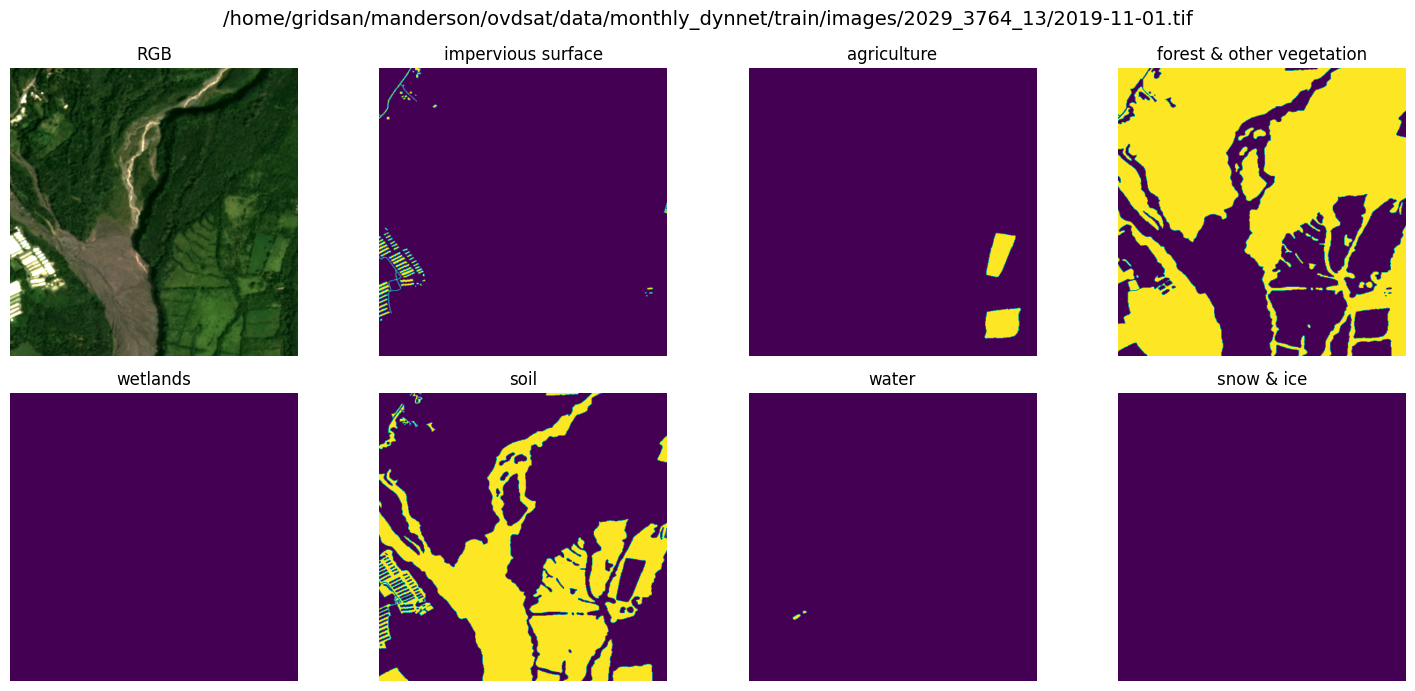

In [14]:
rand_idx = random.randint(0, len(dataobj))

img, mask = dataobj[rand_idx]
#rgb = np.array(np.transpose(img[:-1,:,:], (1, 2, 0)))
rgb = np.array(np.dstack((img[2], img[1], img[0])))
norm_rgb = (rgb - rgb.min())/(rgb.max() - rgb.min())
rs_rgb = rescale(norm_rgb)

# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # Adjust figure size as needed

# Plot each image
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(rs_rgb)
    else:
        ax.imshow(mask[i-1])
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')  # Hide axis
    
plt.suptitle(dataobj.get_id(rand_idx)[0], fontsize=14)
plt.tight_layout()
plt.show()

### Mixing backbones and segmentation decoders

In [17]:
import segmentation_models_pytorch as smp

In [40]:
model = smp.Unet(classes=7, activation=None)

In [45]:
bb = load_backbone('dinov2')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [52]:
del model.encoder

In [53]:
print(model)

Unet(
  (decoder): UnetDecoder(
    (center): Identity()
    (blocks): ModuleList(
      (0): DecoderBlock(
        (conv1): Conv2dReLU(
          (0): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (attention1): Attention(
          (attention): Identity()
        )
        (conv2): Conv2dReLU(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (attention2): Attention(
          (attention): Identity()
        )
      )
      (1): DecoderBlock(
        (conv1): Conv2dReLU(
          (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0